This Notebook is to run do exploratory data analysis on our dataset. 

In [6]:
import pandas as pd
import numpy as np
import os

# --- PART 1: LOAD AND COMBINE ---
root_dir = './Phase2' 
all_dfs = []

if os.path.exists(root_dir):
    for root, dirs, files in os.walk(root_dir):
        folder_name = os.path.basename(root)
        
        for file in files:
            if file.endswith(".csv"):
                file_path = os.path.join(root, file)
                try:
                    temp_df = pd.read_csv(file_path)
                    
                    # Create metadata columns
                    temp_df['author'] = folder_name
                    temp_df['source_file'] = file 
                    
                    # Reorder columns to put author first
                    cols = ['author'] + [c for c in temp_df.columns if c != 'author']
                    temp_df = temp_df[cols]
                    
                    all_dfs.append(temp_df)
                except Exception as e:
                    print(f"Skipping bad file {file}: {e}")
    
    if all_dfs:
        data = pd.concat(all_dfs, ignore_index=True)
        print(f"Successfully combined {len(all_dfs)} files.")
    else:
        print("No CSV files found.")
        data = pd.DataFrame() # Create empty DF to prevent crashes
else:
    print("Phase2 directory not found.")
    data = pd.DataFrame()

# --- PART 2: CLEANING & AGGREGATION ---
if not data.empty:
    # Identify label column (2nd to last, due to added metadata)
    label_col = data.columns[-2] 

    # 1. Clean strings
    data[label_col] = data[label_col].astype(str).str.strip().str.lower()

    # 2. Detect Changes (Logic: Label changes OR File changes)
    data['change'] = (data[label_col] != data[label_col].shift()) | \
                     (data['source_file'] != data['source_file'].shift())
    data['instance_id'] = data['change'].cumsum()

    # 3. Group by Instance (Calculate durations)
    instance_df = data.groupby('instance_id').agg(
        label=(label_col, 'first'),
        duration=(label_col, 'count'),
        author=('author', 'first'),
        file=('source_file', 'first')
    )

    # 4. Filter idle/none
    exclude = ['idle', 'none', 'nan']
    filtered_instances = instance_df[~instance_df['label'].isin(exclude)].copy()

    # 5. Create Summary Table (Needed for Plot A in Chunk 2)
    summary_table = filtered_instances['label'].value_counts().reset_index()
    summary_table.columns = ['Action Label', 'Instance Count']

    # Report
    print(f"Data processed. Found {len(filtered_instances)} valid action instances.")
    
    # Optional: Detailed list of long moves
    long_moves = filtered_instances[filtered_instances['duration'] > 31].sort_values(by='duration', ascending=False)
    if not long_moves.empty:
        print(f"\nFound {len(long_moves)} moves longer than 31 frames.")

Successfully combined 5 files.
Data processed. Found 557 valid action instances.

Found 11 moves longer than 31 frames.


/var/folders/hn/dcy0l7cn53v54k9nvcx14kl80000gn/T/ipykernel_2617/2198638934.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', len(unique_authors))


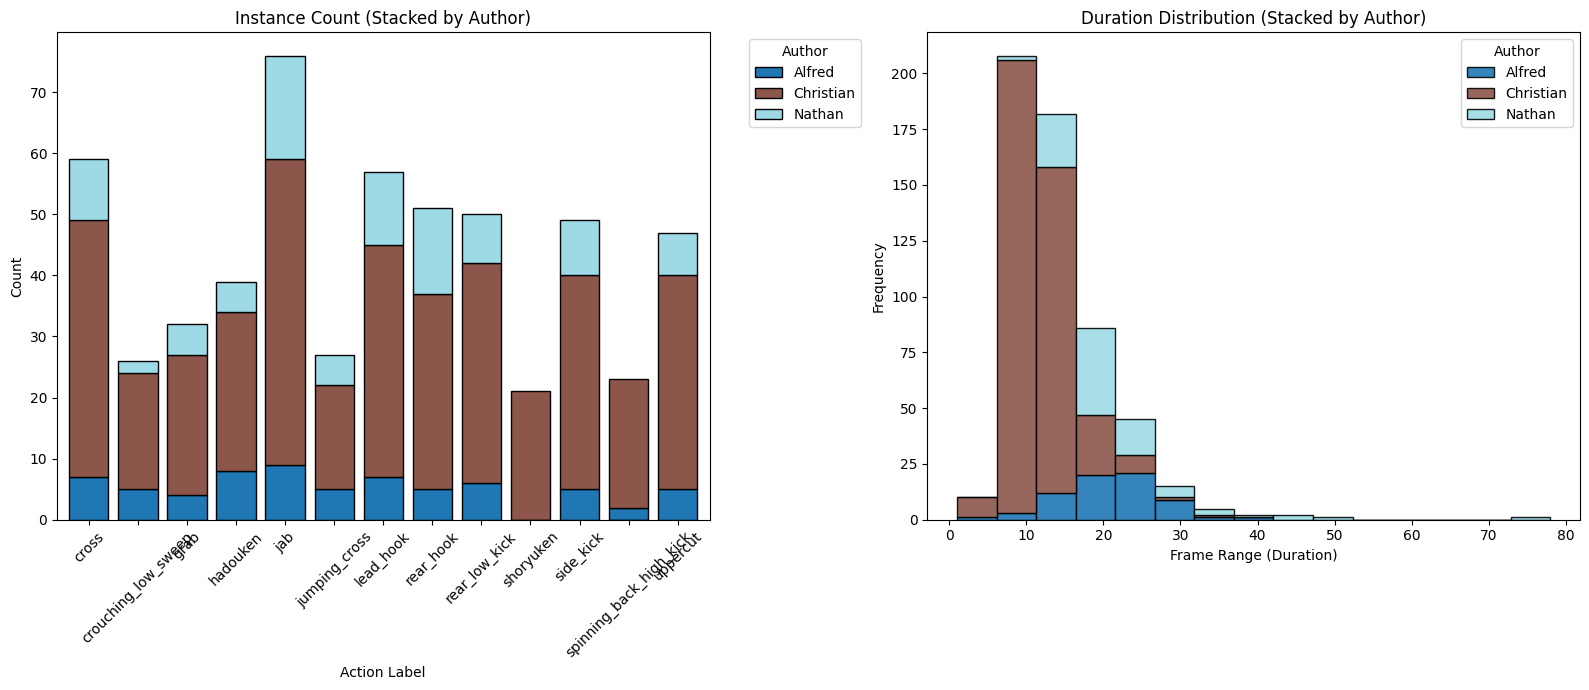

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure data exists before plotting
if 'filtered_instances' in locals() and not filtered_instances.empty:
    
    # 1. SETUP CONSISTENT COLORS
    # Get sorted list of authors so the order is fixed
    unique_authors = sorted(filtered_instances['author'].unique())
    
    # Generate a color palette
    colormap = plt.cm.get_cmap('tab20', len(unique_authors))
    color_list = [colormap(i) for i in range(len(unique_authors))]
    
    # Create a dictionary to map Author -> Color (for Plot 2 consistency)
    author_color_map = dict(zip(unique_authors, color_list))

    # Initialize Figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # --- Plot A: Stacked Bar Chart (Action vs Author) ---
    # We pivot the data: Rows=Actions, Cols=Authors, Values=Count
    pivot_df = pd.crosstab(filtered_instances['label'], filtered_instances['author'])
    
    # Plot using pandas built-in plotting which handles stacking easily
    pivot_df.plot(kind='bar', stacked=True, ax=ax1, color=color_list, edgecolor='black', width=0.8)
    
    ax1.set_title('Instance Count (Stacked by Author)')
    ax1.set_ylabel('Count')
    ax1.set_xlabel('Action Label')
    ax1.legend(title='Author', bbox_to_anchor=(1.05, 1), loc='upper left') # Legend outside to save space
    ax1.tick_params(axis='x', rotation=45)

    # --- Plot B: Stacked Histogram (Duration vs Author) ---
    # Prepare data for matplotlib hist
    stacked_data = []
    stacked_colors = []
    stacked_labels = []

    for author in unique_authors:
        durs = filtered_instances[filtered_instances['author'] == author]['duration']
        # Even if empty, we append to keep color alignment correct, though usually we check len>0
        if len(durs) > 0:
            stacked_data.append(durs)
            stacked_colors.append(author_color_map[author])
            stacked_labels.append(author)

    ax2.hist(stacked_data, bins=15, stacked=True, 
             color=stacked_colors, label=stacked_labels, 
             edgecolor='black', alpha=0.9)

    ax2.set_title('Duration Distribution (Stacked by Author)')
    ax2.set_xlabel('Frame Range (Duration)')
    ax2.set_ylabel('Frequency')
    ax2.legend(title="Author", loc='upper right')

    plt.tight_layout()
    plt.show()

else:
    print("No data available to plot. Please run Chunk 1 first.")